In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import datetime
import os
import sys
sys.path.append('/data100t1/home/wanying/lab_code/utils')
from rank_based_inverse_normal_transformation import inverse_normal_transformation
print('Last run:', datetime.datetime.now().strftime('%Y-%m-%d'))

Last run: 2024-01-08


# 1. Preprocessing
Merge and clean files

In [2]:
print('#', '#'*22, 'Last run:', datetime.datetime.now().strftime('%Y-%m-%d'), '#'*22)

print('\n#', '-'*15, 'Load files', '-'*15)

print('# Load lipidomics, PCA and phenotype files')
fn_lipid_species = '/data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_measures/lipid_species.txt'
fn_lipid_class = '/data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_measures/lipid_classes.txt'
fn_pheno = '/data100t1/share/CCHC/phenotypes/0723/cchc_phenotypes_0723.txt'
fn_pc = '/data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_pca/CCHC_PCair.vectors'

# Load id mapping file
df_id_mapping = pd.read_csv('/data100t1/home/wanying/CCHC/doc/samples_IDs/202211_merged_RNA_lipid_protein_genotype_mapping_and_availability.txt',
                            sep='\t').drop_duplicates(subset='lipidomic').dropna(subset='lipidomic')

df_pheno = pd.read_csv(fn_pheno, sep='|', dtype='str')[['RRID', 'LABID', 'VISIT', 'AGE_AT_VISIT', 'GENDER']]
for col in ['VISIT', 'AGE_AT_VISIT', 'GENDER']:
    df_pheno[col] = pd.to_numeric(df_pheno[col], errors='coerce')
df_lip_species = pd.read_csv(fn_lipid_species, sep='\t').rename(columns={'Sample ID':'LABID'})
df_lip_class = pd.read_csv(fn_lipid_class, sep='\t').rename(columns={'Sample ID':'LABID'})
df_pc = pd.read_csv(fn_pc, sep='\t', header=None).iloc[:,:6].rename(columns={0:'genotype_ID', 1:'PC1', 2:'PC2', 3:'PC3', 4:'PC4', 5:'PC5'})
df_pc = df_id_mapping[['RRID', 'LABID', 'genotype_ID']].merge(df_pc[['genotype_ID', 'PC1', 'PC2',
                                                                     'PC3', 'PC4', 'PC5']], on='genotype_ID')
print('# - Lipid class:', df_lip_class.shape)
print('# - Lipid species:', df_lip_species.shape)
print('# - Phenotype:', df_pheno.shape)
print('# - PCA:', df_pc.shape)

print('\n# Handle special cases: BD2766 and BD6767 have two entires, so replace with the average')
# LABID BD2766 and BD6767 have two entires, so I take the average as the final value
print('# - Lipid species')
display(df_lip_species[df_lip_species['LABID'].duplicated(keep=False)].sort_values(by='LABID').iloc[:, :10])
# Use ~ to negate bitwise boolean mask
df_lip_species = pd.concat([df_lip_species[~df_lip_species['LABID'].duplicated(keep=False)],
                            df_lip_species[df_lip_species['LABID'].duplicated(keep=False)].groupby(by='LABID').mean().reset_index()])
print('# - Lipid class')
display(df_lip_class[df_lip_class['LABID'].duplicated(keep=False)].sort_values(by='LABID').iloc[:, :10])
df_lip_class = pd.concat([df_lip_class[~df_lip_class['LABID'].duplicated(keep=False)],
                          df_lip_class[df_lip_class['LABID'].duplicated(keep=False)].groupby(by='LABID').mean().reset_index()])

# Merge files
print('\n#', '-'*15, 'Merge files', '-'*15)
print('# Merge and clean')
# Sample RRID BD2575 has two visit entries with the same visit number, so sort by age at the end to avoid issue
df_merged = df_pheno.merge(df_lip_class[['LABID']], on='LABID')
df_merged = df_merged.merge(df_pc[['RRID', 'LABID', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5']], on=['RRID', 'LABID']).sort_values(by=['RRID','VISIT','AGE_AT_VISIT'])
n_pre = len(df_merged) # Track number of samples
print('# - (Inital merge) all samples with both lipidomics and genotype data: N=', n_pre, sep='')
df_merged.drop_duplicates(subset='RRID', keep='last', inplace=True)
n_post = len(df_merged) # Track number of samples
print('# - Remove duplicate samples by RRID: N_removed=', n_pre-n_post, sep='')
df_merged.dropna(inplace=True)
n_pre = n_post
n_post = len(df_merged)
print('# - Remove samples with any missing phenotype values in sex, age: N_removed=', n_pre-n_post, sep='')
print('# Final sample size (both lipidomics and genotype, no duplicate, no missing phenotype): N=', len(df_merged), sep='')

# Merge lipid species and lipid class values
df_merged_lip_species = df_merged.merge(df_lip_species, on='LABID')
df_merged_lip_class = df_merged.merge(df_lip_class, on='LABID')


print('\n#', '-'*15, 'Save cleaned outputs', '-'*15)

# Save cleaned outputs
output_fn = '/data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_measures/lipid_species.no_dup.txt'
if not os.path.isfile(output_fn):
    print(f'# - File saved: {output_fn}')
    df_lip_species.replace(np.nan, 'MEAN').to_csv(output_fn, sep='\t', index=False)
else: print(f'# - File exists, skip saving: {output_fn}')
output_fn = '/data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_measures/lipid_species_with_covar.no_dup.txt'
if not os.path.isfile(output_fn):
    print(f'# - File saved: {output_fn}')
    df_merged_lip_species.replace(np.nan, 'MEAN').to_csv(output_fn, sep='\t', index=False)
else: print(f'# - File exists, skip saving: {output_fn}')

output_fn = '/data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_measures/lipid_class.no_dup.txt'
if not os.path.isfile(output_fn):
    print(f'# - File saved: {output_fn}')
    df_lip_class.replace(np.nan, 'MEAN').to_csv(output_fn, sep='\t', index=False)
else: print(f'# - File exists, skip saving: {output_fn}')
output_fn = '/data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_measures/lipid_class_with_covar.no_dup.txt'
if not os.path.isfile(output_fn):
    print(f'# - File saved: {output_fn}')
    df_merged_lip_class.replace(np.nan, 'MEAN').to_csv(output_fn, sep='\t', index=False)
else: print(f'# - File exists, skip saving: {output_fn}')

print('#', '#'*30, 'DONE', '#'*30)



# ###################### Last run: 2023-12-17 ######################

# --------------- Load files ---------------
# Load lipidomics, PCA and phenotype files
# - Lipid class: (2499, 51)
# - Lipid species: (2499, 832)
# - Phenotype: (10544, 5)
# - PCA: (2361, 8)

# Handle special cases: BD2766 and BD6767 have two entires, so replace with the average
# - Lipid species


,MS Label,LABID,Sph(d18:1),Sph(d18:2),S1P(d16:1),S1P(d18:0),S1P(d18:1),S1P(d18:2),dhCer(d18:0/16:0),dhCer(d18:0/18:0)
768,CCHC_02-442_S_E02-V389_BD6766,BD6766,170.308839,38.007999,106.052911,159.576082,1760.174727,282.903138,22.817400,7.635398
1511,CCHC_04-332_S_E04-V289_BD6766,BD6766,383.332749,70.076377,80.287629,255.541928,1628.447076,251.048519,12.535177,5.214205
354,CCHC_01-445_S_E01-V392_BD6767,BD6767,375.481097,63.381353,115.988622,207.018117,1648.914497,322.003797,27.310452,8.370076
1481,CCHC_04-294_S_E04-V255_BD6767,BD6767,134.741717,45.219943,79.442826,185.159845,1353.553933,294.372663,9.760499,5.083516
373,CCHC_01-469_S_E01-V414_BD6768,BD6768,536.609182,95.655284,116.496463,207.992692,1424.671900,206.319641,14.844684,3.484987
894,CCHC_03-090_S_E03-V069_BD6768,BD6768,390.616543,67.763845,83.895553,180.374467,2115.614625,398.147984,23.270751,8.551527
1615,CCHC_04-457_S_E04-V403_BD6768,BD6768,177.150654,38.800827,161.421577,206.370940,1631.177080,329.849129,17.330968,7.185307


# - Lipid class


,MS Label,LABID,Sph,S1P,dhCer,Cer(d),Cer(m),C1P,HexCer,Hex2Cer
768,CCHC_02-442_S_E02-V389_BD6766,BD6766,208.316838,2308.706858,339.778881,10645.840577,713.161636,1.670486,3654.419104,5398.325272
1511,CCHC_04-332_S_E04-V289_BD6766,BD6766,453.409126,2215.325153,187.106361,8377.853696,232.232667,1.669788,3036.869277,3794.860682
354,CCHC_01-445_S_E01-V392_BD6767,BD6767,438.862450,2293.925033,449.285261,15872.230760,1061.834538,1.917350,2678.090839,6322.741776
1481,CCHC_04-294_S_E04-V255_BD6767,BD6767,179.961660,1912.529266,117.027007,8626.929329,289.765030,3.090769,3639.576426,3911.452661
373,CCHC_01-469_S_E01-V414_BD6768,BD6768,632.264466,1955.480696,251.037404,12361.503418,548.770481,2.194238,3279.869369,4290.242039
894,CCHC_03-090_S_E03-V069_BD6768,BD6768,458.380388,2778.032630,400.749706,9676.081415,541.983297,3.793039,3550.135581,8031.003983
1615,CCHC_04-457_S_E04-V403_BD6768,BD6768,215.951481,2328.818727,208.087674,13514.021515,301.998789,4.751872,5075.242213,4213.531207



# --------------- Merge files ---------------
# Merge and clean
# - (Inital merge) all samples with both lipidomics and genotype data: N=2361
# - Remove duplicate samples by RRID: N_removed=72
# - Remove samples with any missing phenotype values in sex, age: N_removed=2
# Final sample size (both lipidomics and genotype, no duplicate, no missing phenotype): N=2287

# --------------- Save cleaned outputs ---------------
# - File exists, skip saving: /data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_measures/lipid_species.no_dup.txt
# - File exists, skip saving: /data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_measures/lipid_species_with_covar.no_dup.txt
# - File exists, skip saving: /data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_measures/lipid_class.no_dup.txt
# - File exists, skip saving: /data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_measures/lipid_class_with_covar.no_dup.txt
# ############################## DONE #####################

# 2. Perform linear regression on lipidomics measures to get residuals
Take residuals of: lipid trait (INVed) ~ sex + age + PC1-5

(Maybe consider lipid lowering meds? But might lose samples due to missing information)

In [6]:
def run_regression_to_get_residual(lip_type='class',
                                   subset=None,
                                   subset_name='',
                                   id_col_name='RRID',
                                   output_dir='/data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_measures',
                                   overwrite=False,
                                   plot=True):
    '''
    Parameters
    - lip_type: type of lipid trait, either species or class
    - subset: a list (or array) of samples to perform inverse normal transformation (INV) and regression.
              Use the whole dataset if subset=None.
              INV result will be different when use the entire or subset of data.
    - subset_name: train or test. Used to label output file name
    - id_col_name: name of the column with IDs to filter for IDs in subsetn list
    - output_dir: directory to save output file
    - overwrite: Overwite existing output file if set to true
    - plot: Plot distribution of randomly selected lipid traits if set to true
    '''
    print('\n#', '-'*15, 'Load lipid measures and covariates', '-'*15)
    # lip_type = 'class'
    in_fn = f'/data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_measures/lipid_{lip_type}_with_covar.no_dup.txt'
    df = pd.read_csv(in_fn, sep='\t')
    # display(df.head())
    if subset is not None: # Only perform in subset of samples if list is provided
        df = df[df[id_col_name].isin(subset)].copy()
        print('# - Number of samples in subset: N =', len(df))
        
    covar_cols = ['AGE_AT_VISIT', 'GENDER', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5']

    print('\n#', '-'*15, 'Run linear regression and save residuals', '-'*15)
    # Lipid trait start from column index 11
    c = 0
    total = len(df.columns[11:]) # Total number of lipid traits
    lst_residual = [] # Store residuals of each lipid trait
    for lip in df.columns[11:]:
        # Run regression
        # Create linear regression object
        # regr_model = LinearRegression().fit(df[covar_cols], df[lip])
        regr_model = LinearRegression().fit(df[covar_cols], inverse_normal_transformation(df[lip])) # Need INV lipid trait first according to the MR-JTI model

        # Make predictions and calcualte residuals
        lst_residual.append(inverse_normal_transformation(df[lip]) - regr_model.predict(df[covar_cols]))

        c += 1
        print(f'\r# Lipid {lip_type} processed: {c}/{total}  ', end='', flush=True)
    # Concat on columns is done by index, so need to make the two dfs have the same index style
    df_residual = pd.concat([df[['RRID', 'LABID']].reset_index(drop=True),
                             pd.DataFrame(data=np.array(lst_residual).transpose(), columns=df.columns[11:])],
                            axis=1)

    # Plot residuals to check distribution
    if plot:
        print('\n# - Check distribution of residuals of a few random lipid traits')
        nrows, ncols = 5, 6
        fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,8))
        df_plot_subset = df_residual.iloc[:, 2:].sample(n=nrows*ncols, axis=1, random_state=5)
        row, col = 0, 0
        for lip in df_plot_subset.columns:
            ax[row, col].hist(df_plot_subset[lip], bins=30)
            ax[row, col].set_title(lip)
            if col<ncols-1:
                col += 1
            else:
                col = 0
                row += 1
        fig.suptitle(f'({lip_type} {subset_name}, N={len(df)}) Residuals from model: lipid trait (INVed) ~ sex + age + PC1-5')
        fig.tight_layout()
        plt.show()
    
    print('\n#', '-'*15, 'Save files', '-'*15)
    output_fn = f'{output_dir}/lipid_{lip_type}_with_covar.no_dup.residual.{subset_name}.txt'
    if not os.path.isfile(output_fn) or overwrite:
        print(f'# - File saved: {output_fn}')
        df_residual.to_csv(output_fn, sep='\t', index=False)
    else: print(f'# - File exists, skip saving: {output_fn}')
    print('\n#', '#'*30, 'DONE', '#'*30)
    return df_residual

## 2.1 Lipid class

# samples in training set (3rd degree relatedness): 1607
# samples in test set (rest of available samples): 793

# --------------- Load lipid measures and covariates ---------------
# - Number of samples in subset: N = 1606

# --------------- Run linear regression and save residuals ---------------
# Lipid class processed: 49/49  
# - Check distribution of residuals of a few random lipid traits


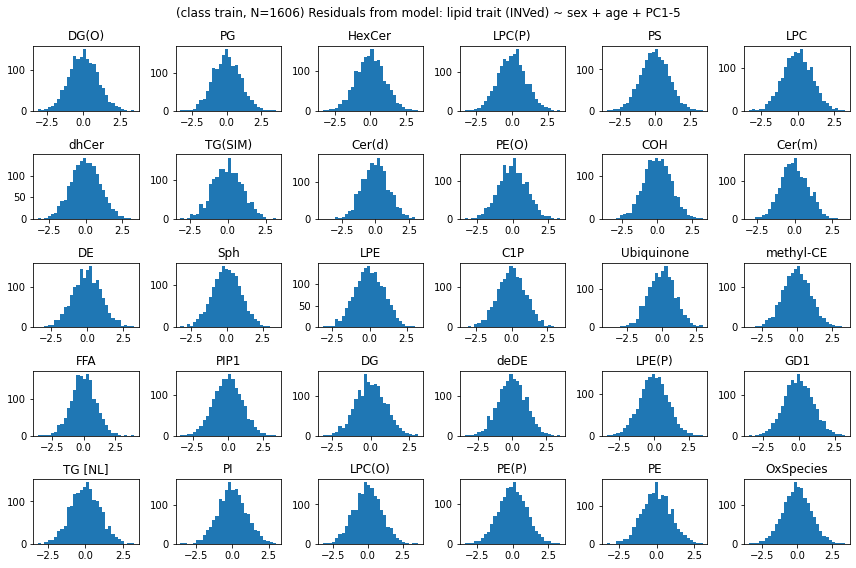


# --------------- Save files ---------------
# - File exists, skip saving: /data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_measures/lipid_class_with_covar.no_dup.residual.train.txt

# ############################## DONE ##############################

# --------------- Load lipid measures and covariates ---------------
# - Number of samples in subset: N = 681

# --------------- Run linear regression and save residuals ---------------
# Lipid class processed: 49/49  
# - Check distribution of residuals of a few random lipid traits


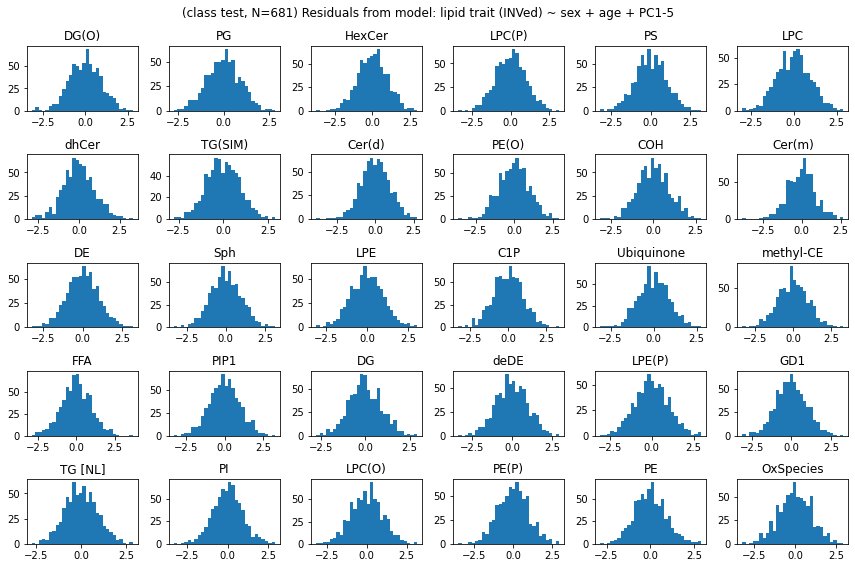


# --------------- Save files ---------------
# - File exists, skip saving: /data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_measures/lipid_class_with_covar.no_dup.residual.test.txt

# ############################## DONE ##############################


In [7]:
# Load list of train and test set
df_id_mapping = pd.read_csv('/data100t1/home/wanying/CCHC/doc/samples_IDs/202211_merged_RNA_lipid_protein_genotype_mapping_and_availability.txt',
                            sep='\t').drop_duplicates(subset=['lipidomic']).dropna(subset=['RRID', 'lipidomic']).drop_duplicates(subset='RRID')
df_train = pd.read_csv('/data100t1/home/wanying/CCHC/lipidomics/input_docs/primus/primus_rel_3/plink.genome_maximum_independent_set', sep='\t')
df_train = df_id_mapping.merge(df_train, left_on='genotype_ID', right_on='FID')

# Rest of the samples all go to test set
df_test = df_id_mapping[~df_id_mapping['LABID'].isin(df_train['LABID'])]
print('# samples in training set (3rd degree relatedness):', len(df_train['LABID']))
print('# samples in test set (rest of available samples):', len(df_test['LABID']))

df_class_residual_train = run_regression_to_get_residual(lip_type='class',
                                                         subset=df_train['RRID'],
                                                         subset_name='train',
                                                         overwrite=False, plot=True)
df_class_residual_test = run_regression_to_get_residual(lip_type='class',
                                                        subset=df_test['RRID'],
                                                        subset_name='test',
                                                        overwrite=False, plot=True)

## 2.2 Lipid species

In [ ]:
'''
print('\n#', '-'*15, 'Load lipid measures and covariates', '-'*15)
lip_type = 'species'
in_fn = f'/data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_measures/lipid_{lip_type}_with_covar.no_dup.txt'
df = pd.read_csv(in_fn, sep='\t')
display(df.head())
covar_cols = ['AGE_AT_VISIT', 'GENDER', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5']

print('\n#', '-'*15, 'Run linear regression and save residuals', '-'*15)
# Lipid trait start from column index 11
c = 0
total = len(df.columns[11:]) # Total number of lipid traits
lst_residual = [] # Store residuals of each lipid trait
for lip in df.columns[11:]:
    # Run regression
    # Create linear regression object
    regr_model = LinearRegression().fit(df[covar_cols], df[lip])
    # regr_model = LinearRegression().fit(df[covar_cols], inverse_normal_transformation(df[lip])) # Need INV lipid trait first according to the MR-JTI model

    # Make predictions and calcualte residuals
    # df_residual[lip] = df[[lip]] - regr_model.predict(df[covar_cols])
    lst_residual.append(df[lip].values - regr_model.predict(df[covar_cols]))
    c += 1
    print(f'\r# Lipid {lip_type} processed: {c}/{total}  ', end='', flush=True)
df_residual = pd.concat([df[['RRID', 'LABID']],
                         pd.DataFrame(data=np.array(lst_residual).transpose(), columns=df.columns[11:])],
                        axis=1)

# Plot residuals to check distribution
print('\n# - Check distribution of residuals from a few random lipid traits')
nrows, ncols = 5, 6
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,8))
df_plot_subset = df_residual.iloc[:, 2:].sample(n=nrows*ncols, axis=1, random_state=5)
row, col = 0, 0
for lip in df_plot_subset.columns:
    ax[row, col].hist(df_plot_subset[lip], bins=30)
    ax[row, col].set_title(lip)
    if col<ncols-1:
        col += 1
    else:
        col = 0
        row += 1
fig.suptitle(f'({lip_type}) Residuals from model: lipid trait ~ sex + age + PC1-5')
fig.tight_layout()

# INV residuals for later analysis
print('\n#', '-'*15, 'INV residuals', '-'*15)
lst_inv_residual = [inverse_normal_transformation(x) for x in lst_residual]
df_inv_residual = pd.concat([df[['RRID', 'LABID']],
                             pd.DataFrame(data=np.array(lst_inv_residual).transpose(), columns=df.columns[11:])],
                            axis=1)
print('# - Check distribution of residuals from a few random lipid traits')
nrows, ncols = 5, 6
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,8))
df_plot_subset = df_inv_residual.iloc[:, 2:].sample(n=nrows*ncols, axis=1, random_state=5)
row, col = 0, 0
for lip in df_plot_subset.columns:
    ax[row, col].hist(df_plot_subset[lip], bins=30)
    ax[row, col].set_title(lip)
    if col<ncols-1:
        col += 1
    else:
        col = 0
        row += 1
fig.suptitle('INVed Residuals')
fig.tight_layout()

print('\n#', '-'*15, 'Save files', '-'*15)
output_fn = f'/data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_measures/lipid_{lip_type}_with_covar.no_dup.residual.txt'
if not os.path.isfile(output_fn):
    print(f'# - File saved: {output_fn}')
    df_residual.to_csv(output_fn, sep='\t', index=False)
else: print(f'# - File exists, skip saving: {output_fn}')

output_fn = f'/data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_measures/lipid_{lip_type}_with_covar.no_dup.residual.INVed.txt'
if not os.path.isfile(output_fn):
    print(f'# - File saved: {output_fn}')
    df_inv_residual.to_csv(output_fn, sep='\t', index=False)
else: print(f'# - File exists, skip saving: {output_fn}')

print('\n#', '#'*30, 'DONE', '#'*30)
'''


# --------------- Load lipid measures and covariates ---------------
# - Number of samples in subset: N = 1606

# --------------- Run linear regression and save residuals ---------------
# Lipid species processed: 830/830  
# - Check distribution of residuals of a few random lipid traits


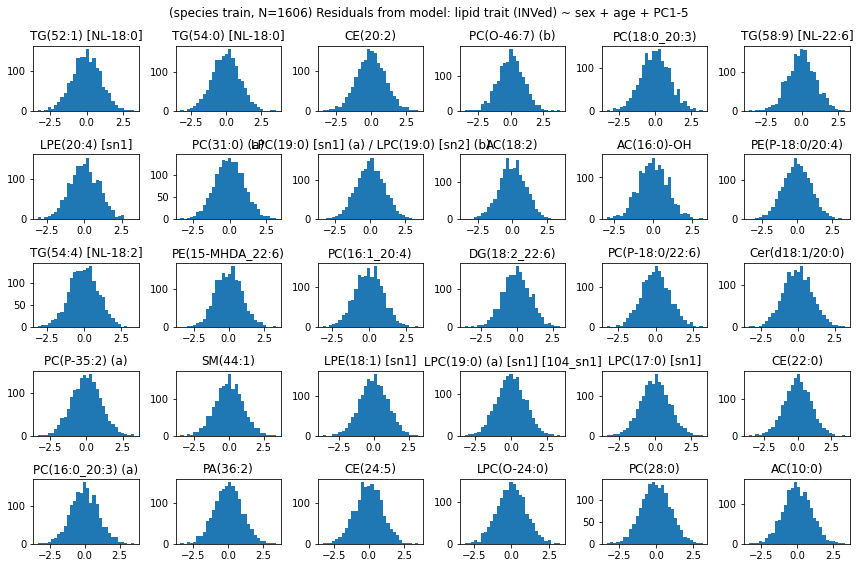


# --------------- Save files ---------------
# - File exists, skip saving: /data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_measures/lipid_species_with_covar.no_dup.residual.train.txt

# ############################## DONE ##############################

# --------------- Load lipid measures and covariates ---------------
# - Number of samples in subset: N = 681

# --------------- Run linear regression and save residuals ---------------
# Lipid species processed: 830/830  
# - Check distribution of residuals of a few random lipid traits


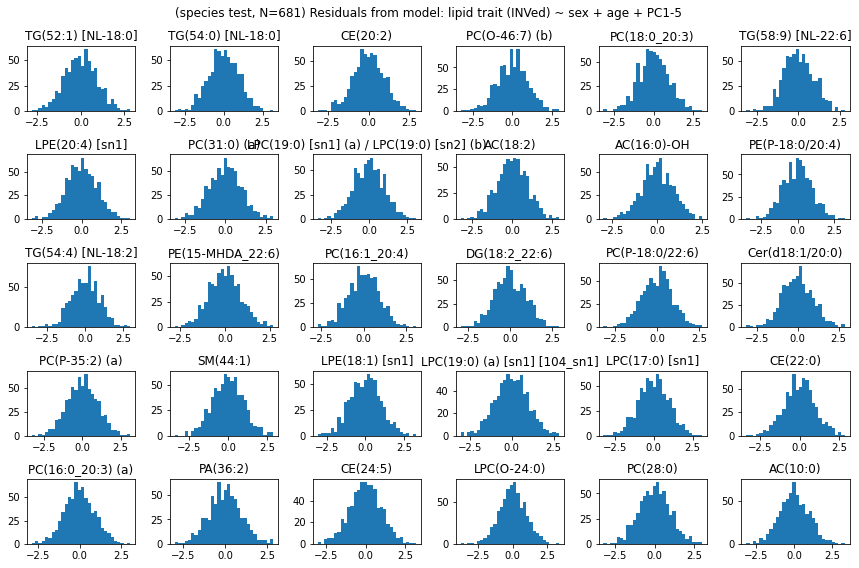


# --------------- Save files ---------------
# - File exists, skip saving: /data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_measures/lipid_species_with_covar.no_dup.residual.test.txt

# ############################## DONE ##############################


In [8]:
df_species_residual_train = run_regression_to_get_residual(lip_type='species',
                                                           subset=df_train['RRID'],
                                                           subset_name='train',
                                                           overwrite=False, plot=True)
df_species_residual_test = run_regression_to_get_residual(lip_type='species',
                                                          subset=df_test['RRID'],
                                                          subset_name='test',
                                                          overwrite=False, plot=True)


## 2.3 Compare residuals to the old files I used for model training in the first round
They match! (opposite signs were cause by using pred-obs in the previous calculation)

# Compare new residuals to old residuals in training set


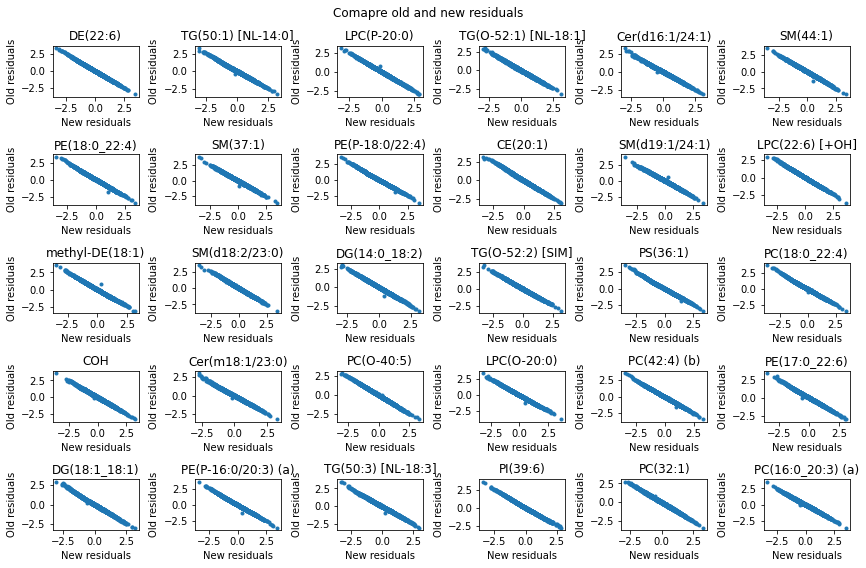

In [29]:
fn_old = '/data100t1/home/wanying/CCHC/lipidomics/prediction_models/input_docs/lipid_traits_residuals/train/lipid_species_residuals_adj_for_sex_age_pc1-5.txt.reformatted'
df_lip_species_residual_old = pd.read_csv(fn_old, sep='\t')
df_lip_species_residual_old.head()

df_merged_compare = df_species_residual_train.merge(df_lip_species_residual_old.rename(columns={'Sample ID':'LABID'}),
                                                    on='LABID',
                                                    suffixes=('_new', '_old'))
# df_merged_compare.iloc[:, 2:]

print('# Compare new residuals to old residuals in training set')
nrows, ncols = 5, 6
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,8))
lipid_subset_idx = np.random.randint(low=1,
                                     high=df_lip_species_residual_old.shape[-1],
                                     size=nrows*ncols) # Get indices of random lipid trait
row, col = 0, 0
for lip in df_lip_species_residual_old.columns[lipid_subset_idx]:
    ax[row, col].plot(df_merged_compare[f'{lip}_new'], df_merged_compare[f'{lip}_old'], ls='', marker='.')
    ax[row, col].set_title(lip)
    ax[row, col].set_xlabel('New residuals')
    ax[row, col].set_ylabel('Old residuals')
    if col<ncols-1:
        col += 1
    else:
        col = 0
        row += 1
    
fig.suptitle('Comapre old and new residuals')
fig.tight_layout()
plt.show()


# 3. Prepare files for fastGWA

## 3.1 Create outcome files using INVed residuals

In [15]:
# 3rd degree Max unrelated set: /data100t1/home/wanying/CCHC/lipidomics/input_docs/primus/primus_rel_3/plink.genome_maximum_independent_set

# Create one phenotype file for each lipid trait
# No need to adjust for other covariates since thay have been accounted for to generate the residuals
# Split the genetype ID to match the FID and IID in the plink file
def save_pheno_files(lip_type):
    print(f'# Load lipid {lip_type} residuals and ID mapping file. Find pout FID and IID used in plink files (split genetype ID by "_")')
    fn = f'/data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_measures/lipid_{lip_type}_with_covar.no_dup.residual.train.txt'
    df_lipid_residuals = pd.read_csv(fn, sep='\t')

    # Load id mapping file
    df_id_mapping = pd.read_csv('/data100t1/home/wanying/CCHC/doc/samples_IDs/202211_merged_RNA_lipid_protein_genotype_mapping_and_availability.txt',
                                sep='\t').drop_duplicates(subset='lipidomic').dropna(subset='lipidomic')

    df_lipid_residuals = df_id_mapping[['RRID', 'genotype_ID']].drop_duplicates(subset='RRID').merge(df_lipid_residuals, on='RRID')
    df_lipid_residuals['FID'] = df_lipid_residuals['genotype_ID'].apply(lambda x: x.split('_')[0])
    df_lipid_residuals['IID'] = df_lipid_residuals['genotype_ID'].apply(lambda x: x.split('_')[-1])
    # display(df_lipid_residuals.head(2))

    print('# Save phenotype file of individual lipid trait')
    output_dir = f'/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/supporting_files/GWAS_files/lipid_{lip_type}'
    c = 0
    for lip in df_lipid_residuals.columns[3:-2]:
        # Fix lipid names to avoid special characters
        output_fn = lip.replace('\\', '-').replace('/', '-').replace('(','-').replace(')','-').replace(' ','_') + '.pheno'
        df_lipid_residuals[['FID', 'IID', lip]].to_csv(f'{output_dir}/{output_fn}', sep=' ', index=False, header=False)
        c += 1
        print(f'\r# - Lipod trait saved:{c}/{df_lipid_residuals.shape[1]-5}', flush=True, end='')
    print('\n# DONE\n')
    return df_lipid_residuals

In [16]:
df_lipid_species_residuals = save_pheno_files(lip_type='species')
df_lipid_class_residuals = save_pheno_files(lip_type='class')

# Load lipid species residuals and ID mapping file. Find pout FID and IID used in plink files (split genetype ID by "_")
# Save phenotype file of individual lipid trait
# - Lipod trait saved:830/830
# DONE

# Load lipid class residuals and ID mapping file. Find pout FID and IID used in plink files (split genetype ID by "_")
# Save phenotype file of individual lipid trait
# - Lipod trait saved:49/49
# DONE



In [19]:
# Save list of samples to use by --keep in fastGWA
output_dir = '/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/supporting_files/GWAS_files'
out_fn = 'samples_ids_for_fastGWA.train.txt'
df_lipid_species_residuals[['FID', 'IID']].to_csv(f'{output_dir}/{out_fn}', sep=' ', index=False, header=False)


## 3.2 fastGWA command

Model used (No need to add covariates since using residuals):
INV(lipid) residual ~ SNP

In [ ]:
%%bash
# Saved in bash file and run in commandline as:
#     ./GWAS_02_run_fastGWA.sh AC-OH class
# Format of --pheno, --qcovar and --covar can be found here:
# https://gcta.freeforums.net/thread/510/limit-on-qcovars-fastgwa
# Only perform analysis in subst of samples specified by --keep
lipid=$1
lipid_type=$2 # class or species
output_dir=/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/outputs/fastGWA/lipid_${lipid_type}
keep_list=/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/supporting_files/GWAS_files/samples_ids_for_fastGWA.train.txt

gcta64 --mbfile /data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_sample_plink_imputed/plink_files.txt \
--grm-sparse /data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_GRM/lipidomic_sp_grm \
--fastGWA-mlm \
--pheno /data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/supporting_files/GWAS_files/lipid_${lipid_type}/${lipid}.pheno \
--keep ${keep_list} \
--save-fastGWA-mlm-residual \
--thread-num 16 \
--out ${output_dir}/${lipid}
# --qcovar /data100t1/home/wanying/CCHC/lipidomics/input_docs/pheno_covar_files/AGE_AT_VISIT-AGE2-PC1-PC2-PC3-PC4-PC5-BMI1.qcovar \
# --covar /data100t1/home/wanying/CCHC/lipidomics/input_docs/pheno_covar_files/GENDER.covar \

In [31]:
# Create list of commands to run in commandline
def save_cmd_list(lip_type, df):
    code_dir = '/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/code'
    output_fn = f'/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/code/run_fasGWA_cmds.lipid_{lip_type}.txt'
    fh = open(output_fn, 'w')
    c = 0
    for lip in df.columns[3:-2]:
        lip = lip.replace('\\', '-').replace('/', '-').replace('(','-').replace(')','-').replace(' ','_')
        cmd = f'{code_dir}/GWAS_02_run_fastGWA.sh {lip} {lip_type}'
        fh.write(cmd+'\n')
        c += 1
        print(f'\r# - Lipid trait saved: {c}/{df.shape[1]-5}', flush=True, end='')

    fh.close()
    print('\n# DONE\n')


In [33]:
save_cmd_list(lip_type = 'class', df = df_lipid_class_residuals)
save_cmd_list(lip_type = 'species', df = df_lipid_species_residuals)

# Run with SLURM


# - Lipid trait saved: 49/49
# DONE

# - Lipid trait saved: 830/830
# DONE



# 4. Calculate heritability using residuals
Run heritability using the max unrelated samples\
Modified from ~/CCHC/lipidomics/code/0_rerun_heritability_GREML_with_filtered_SNPs.ipynb and ~/CCHC/lipidomics/code/heritability_estimation_GREML_train_set_only.sh

In [ ]:
# TODO: Create subset of SNPs to estimate h2
# According to GCTA, not recommend using SNOs filtered by GWAS on the same samples. Will see inflation
# But filter by MAF might be ok
# https://yanglab.westlake.edu.cn/software/gcta/#FAQ
# Filter SNPs by MAF of 0.01

In [ ]:
%%bash
# Run a REML analysis on training set only, use a list to specify indlucded sample IDs
lipid=$1
lipid_type=$2 # class or species
output_dir=/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/outputs/fastGWA/heritability_estimation/${lipid_type}
keep_list=/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/supporting_files/GWAS_files/samples_ids_for_fastGWA.train.txt
grm=/data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_GRM/lipidomic_grm

gcta64 --reml \
--keep ${keep_list} \
--grm ${grm} \
--pheno /data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/supporting_files/GWAS_files/lipid_${lipid_type}/${lipid}.pheno \
--qcovar /data100t1/home/wanying/CCHC/lipidomics/input_docs/pheno_covar_files/AGE_AT_VISIT-PC1-PC2-PC3-PC4-PC5.qcovar \
--covar /data100t1/home/wanying/CCHC/lipidomics/input_docs/pheno_covar_files/GENDER.covar \
--thread-num 32 \
--out ${output_dir}/${lipid}

In [ ]:
%%bash
# Run a REML analysis on training set only, use a list to specify indlucded sample IDs, without adjustment of other covariates
lipid=$1
lipid_type=$2 # class or species
output_dir=/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/outputs/fastGWA/heritability_estimation/${lipid_type}
keep_list=/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/supporting_files/GWAS_files/samples_ids_for_fastGWA.train.txt
grm=/data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_GRM/lipidomic_grm

gcta64 --reml \
--keep ${keep_list} \
--grm ${grm} \
--pheno /data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/supporting_files/GWAS_files/lipid_${lipid_type}/${lipid}.pheno \
--thread-num 32 \
--out ${output_dir}/${lipid}

In [2]:
# Create commands to run
def get_lip_list(fn):
    # Get list of lipid names from file
    lst_lipid = []
    with open(fn) as fh:
        line = fh.readline().strip()
        while line != '':
            lst_lipid.append(line.replace('\\', '-').replace('/', '-').replace('(','-').replace(')','-').replace(' ','_'))
            line = fh.readline().strip()
    return lst_lipid

# species
with open('cmd_GWAS_02_run_heritability_estimation_species.txt', 'w') as out_fh:
    lst_species = get_lip_list('/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/inputs/lipid_trait/lipid_species.list')
    for lipid in lst_species:
        cmd = f'bash /data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/code/GWAS_02_run_GCTA_heritability_estimation.sh {lipid} species'
        out_fh.write(cmd+'\n')

# class
with open('cmd_GWAS_02_run_heritability_estimation_class.txt', 'w') as out_fh:
    lst_class = get_lip_list('/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/inputs/lipid_trait/lipid_class.list')
    for lipid in lst_class:
        cmd = f'bash /data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/code/GWAS_02_run_GCTA_heritability_estimation.sh {lipid} class'
        out_fh.write(cmd+'\n')
print('# DONE')

# species
with open('cmd_GWAS_02_run_heritability_estimation_species_no_covar.txt', 'w') as out_fh:
    lst_species = get_lip_list('/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/inputs/lipid_trait/lipid_species.list')
    for lipid in lst_species:
        cmd = f'bash /data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/code/GWAS_02_run_GCTA_heritability_estimation.sh {lipid} species false'
        out_fh.write(cmd+'\n')

# class
with open('cmd_GWAS_02_run_heritability_estimation_class_no_covar.txt', 'w') as out_fh:
    lst_class = get_lip_list('/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/inputs/lipid_trait/lipid_class.list')
    for lipid in lst_class:
        cmd = f'bash /data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/code/GWAS_02_run_GCTA_heritability_estimation.sh {lipid} class false'
        out_fh.write(cmd+'\n')
print('# DONE: GREML without covariates')

# DONE: GREML without covariates


In [10]:
# Merge heritability output into a single file
def merge_h2_outcome(h2_dir, output_fn, overwrite=False):
    c = 0
    if os.path.isfile(output_fn) and not overwrite:
        print('# - Output file exists. Skip saving:', output_fn)
        return
    out_fh = open(output_fn, 'w')
    out_fh.write(f'Lipid_name\th2\tse\n')
    for fn in os.listdir(h2_dir):
        if fn.endswith('.hsq'):
            lipid = fn.split('.hsq')[0]
            with open(os.path.join(h2_dir, fn)) as fh:
                for line in fh:
                    if line.startswith('V(G)/Vp'): # Locate h2 line
                        _, h2, se = line.split()
                        break
                out_fh.write(f'{lipid}\t{h2}\t{se}\n')
            c += 1
    # print(f'\r# - File processed: {c}', end='', flush=True)
    print(f'# - File processed: {c}')
    out_fh.close()

h2_dir = '/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/outputs/fastGWA/heritability_estimation'
lst_lip_type = ['class', 'species']
lst_covar_option = ['_no_covar', '']
output_dir = '/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/outputs/fastGWA/heritability_estimation'
for lip_type in lst_lip_type:
    for covar_option in lst_covar_option:
        print(f'\n# Process {lip_type}{covar_option}')
        merge_h2_outcome(os.path.join(h2_dir, lip_type+covar_option),
                         f'{output_dir}/heritability_{lip_type}{covar_option}.train_only.txt', True)




# Process class_no_covar
# - File processed: 49

# Process class
# - File processed: 49

# Process species_no_covar
# - File processed: 830

# Process species
# - File processed: 830


# 5 . (TBD) Compare to old h2 estimations

# 6. Plot model performance against heritability

In [19]:
def load_h2_data_calcualte_95CI(lip_type = 'species',
                                h2_merged_dir = '/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/outputs/fastGWA/heritability_estimation/merged_heritability_results', h2_fn=''):
    '''
    Load heritability and calculate 95% confidence interval
    :param lip_type:
    :param h2_merged_dir:
    :param h2_fn:
    :return: a dataframe of heritability
    '''
    if h2_fn=='': h2_fn = f'heritability_{lip_type}.train_only.txt'
    print('# Load heritability')
    df_h2 = pd.read_csv(os.path.join(h2_merged_dir, h2_fn), sep='\t')
    print('# Calculate 95% CI')
    # calcualte 95% confidence interval
    # "For normal distribution, a 95% confidence interval is obtained as the values 1.96×SE either side of the mean."
    df_h2['95CI'] = 1.96*df_h2['se']
    return df_h2

def load_perforamnce_Data(fn_performance):
    pass
    # return df_perforamnce

h2_fn = f'heritability_{lip_type}.train_only.txt'
df_h2 = load_h2_data_calcualte_95CI(lip_type = 'species',
                                    h2_merged_dir = '/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/outputs/fastGWA/heritability_estimation/merged_heritability_results',
                                    h2_fn='')
print('# Load performance data')


# Load heritability
# Calculate 95% CI


,Lipid_name,h2,se,95CI
0,CE-18:2-,0.000001,0.183280,0.359229
1,AC-13:0-,0.135327,0.188002,0.368484
2,SM-d19:1-24:1-,0.340741,0.197252,0.386614
3,TG-54:0-_[SIM],0.000001,0.188249,0.368968
4,PC-36:4-_[+OH],0.641321,0.183096,0.358868
...,...,...,...,...
825,PC-16:0_20:3-_-b-,0.000001,0.176448,0.345838
826,Hex2Cer-d18:1-16:0-,0.000001,0.182026,0.356771
827,PC-15-MHDA_22:6-,0.412306,0.199432,0.390887
828,PE-P-17:0-22:6-_-a-,0.292831,0.188449,0.369360
